# This notebook is for modeling both scan directions together and calculating the chisquare statistic for 1, 2, and 3-T models

In [2]:
from preamble import *

In [62]:
import os
import re
import numpy as np
import astropy.units as u
from scipy.interpolate import LinearNDInterpolator

def get_interpolated_spectrum(teff, logg, logz, cto_ratio, data_dir):
    """
    Interpolates spectra for the given parameters from the spectral library.

    Args:
        teff (float): Effective temperature (Teff).
        logg (float): Surface gravity (logg).
        logz (float): Metallicity (logZ).
        cto_ratio (float): C-to-O ratio.
        data_dir (str): Path to the directory containing spectral files.

    Returns:
        tuple: (wavelength, flux), where wavelength is in micrometers
               and flux is interpolated and in erg/s/cm^2/Å.
    """
    # Regex pattern to extract Teff, logg, logZ, and CtoO from filenames
    pattern = r"Teff_(\d+\.\d+)_logg_(\d+\.\d+)_logZ_([-+]?\d+\.\d+)_CtoO_(\d+\.\d+)"
    param_points = []
    fluxes = []
    wavelengths = None

    # Parse all files in the directory
    for filename in os.listdir(data_dir):
        match = re.search(pattern, filename)
        if match:
            file_teff = float(match.group(1))
            file_logg = float(match.group(2))
            file_logz = float(match.group(3))
            file_cto = float(match.group(4))

            # Load the spectrum data
            filepath = os.path.join(data_dir, filename)
            data = np.loadtxt(filepath, comments="#")
            wl = data[:, 0]  # Wavelength (micrometers)
            flux = data[:, 1] * (u.W / u.m**2 / u.m)

            # Convert flux to erg/s/cm^2/Å
            flux = flux.to(u.erg / u.s / u.cm**2 / u.Angstrom,
                           equivalencies=u.spectral_density(wl * u.micron)).value

            # Align wavelength grid
            if wavelengths is None:
                wavelengths = wl
            elif not np.allclose(wavelengths, wl):
                raise ValueError(f"Wavelength grid mismatch in file {filename}")

            # Store parameter point and flux
            param_points.append((file_teff, file_logg, file_logz, file_cto))
            fluxes.append(flux)

    # Ensure we have data to interpolate
    if not param_points or not fluxes:
        raise ValueError("No valid spectra found in the directory.")

    # Interpolate in parameter space
    param_points = np.array(param_points)
    fluxes = np.array(fluxes)
    interpolator = LinearNDInterpolator(param_points, fluxes)

    # Interpolated flux for the input parameters
    interpolated_flux = interpolator((teff, logg, logz, cto_ratio))
    if interpolated_flux is None:
        raise ValueError("Interpolation failed; parameters may be out of range.")

    return wavelengths, interpolated_flux

(0.8, 1.65)

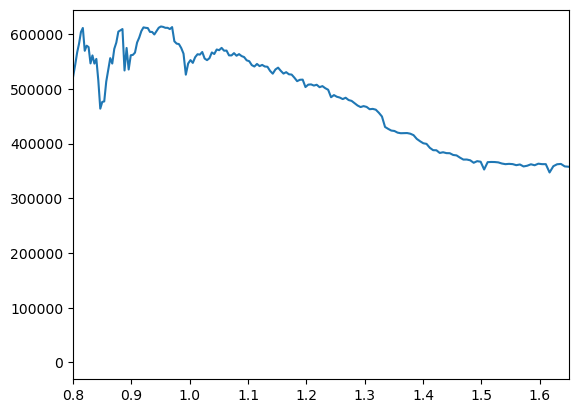

In [66]:
data_directory = "/Users/wiwa8630/sphinx/SPECTRA/"

# Input parameters
teff = 3650
logg = 4.52
logz = 0.12
cto_ratio = 0.5

wavelength, flux = get_interpolated_spectrum(teff, logg, logz, cto_ratio, data_directory)

plt.plot(wavelength, flux)
plt.xlim(0.8,1.65)

Adjusted CtoO ratio: 0.5 (from input 0.5)
Closest match: Teff_3600.0_logg_4.5_logZ_+0.0_CtoO_0.5_spectra.txt (distance: 50.00)


(0.8, 1.65)

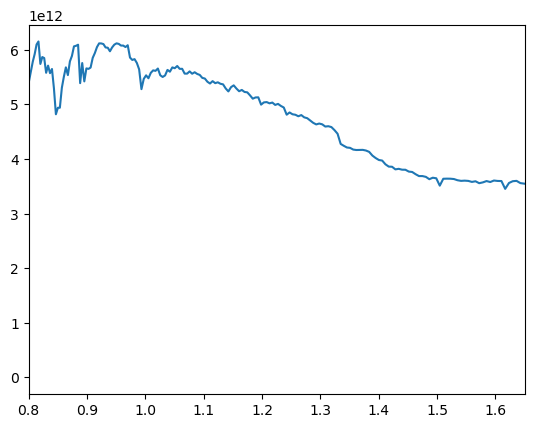

In [59]:
# Directory of spectra files
data_directory = "/Users/wiwa8630/sphinx/SPECTRA/"

# Input parameters
teff = 3650
logg = 4.52
logz = 0.12
cto_ratio = 0.5

# Find the closest file and extract spectrum
wavelength, flux = get_spectrum(teff, logg, logz, cto_ratio, data_directory)

plt.plot(wavelength, flux)
plt.xlim(0.8,1.65)

In [53]:
import astropy.units as u

_flux = flux * (u.W / u.m**2 / u.m)  # Second column: Flux with assigned units

flux_density = _flux.to(u.erg / u.s / u.cm**2 / u.Angstrom,
               equivalencies=u.spectral_density(wavelength * u.micron))

In [55]:
print(_flux)

[1.01091102e+11 8.82826014e-07 1.15188790e-06 ... 4.51872119e+08
 4.50641897e+08 4.33318640e+08] W / m3


In [26]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

def get_sphinx_spectrum(temperature, metallicity, logg, data_dir='/Users/wiwa8630/sphinx/SPECTRA/'):
    """
    Interpolates between spectra files for given temperature, metallicity, and logg.

    Args:
        temperature (float): Effective temperature (Teff).
        metallicity (float): Metallicity (logZ).
        logg (float): Surface gravity (logg).
        data_dir (str): Path to the directory containing spectral files.

    Returns:
        wavelengths (ndarray): Array of wavelength values (micrometer).
        flux (ndarray): Interpolated flux values corresponding to the wavelengths.
    """
    # Step 1: Parse filenames to extract parameter values
    spectra_files = [f for f in os.listdir(data_dir) if f.endswith('.txt')]
    file_params = []
    
    pattern = r"Teff_(\d+\.\d+)_logg_(\d+\.\d+)_logZ_([-+]?\d+\.\d+)"
    for file in spectra_files:
        match = re.search(pattern, file)
        if match:
            teff = float(match.group(1))
            logg_val = float(match.group(2))
            logz = float(match.group(3))
            file_params.append((teff, logg_val, logz, file))
    
    # Step 2: Read and organize data from all files
    param_points = []
    flux_data = []
    wavelengths = None

    for teff, logg_val, logz, file in file_params:
        filepath = os.path.join(data_dir, file)
        data = np.loadtxt(filepath, comments="#", delimiter=None)
        wl = data[:, 0]  # Wavelength
        flux = data[:, 1]  # Flux

        # Ensure all files share the same wavelength grid
        if wavelengths is None:
            wavelengths = wl
        elif not np.allclose(wavelengths, wl):
            raise ValueError(f"Wavelength grid mismatch in file {file}")

        param_points.append((teff, logg_val, logz))
        flux_data.append(flux)

    # Step 3: Interpolate flux data
    param_points = np.array(param_points)
    flux_data = np.array(flux_data)

    interpolator = LinearNDInterpolator(param_points, flux_data)
    interpolated_flux = interpolator((temperature, logg, metallicity))

    if interpolated_flux is None:
        raise ValueError("Interpolation failed; parameters may be out of range.")

    return wavelengths, interpolated_flux

In [ ]:
def sphinx_1T(parameters, sigma, convolution_method='astropy', kernel_type='astropy'):

    T_phot = parameters['T_phot']
    rstar = parameters['R_star']
    
    solid_angle = (( (rstar * u.R_sun)/(9.714*u.parsec) ).decompose() )**2
    
    S_phot = get_sphinx_spectrum(temperature = float(T_phot), metallicity = 0.12, logg= 4.52)

    # Convolve the model spectrum
    convolved = convolve_spectrum(model_wave, model_flux, sigma=sigma, method = convolution_method, kernel_type = kernel_type)
    
    return convolved
    
def sphinx_2T(parameters, sigma, convolution_method='astropy', kernel_type='astropy'):

    T_phot = parameters['T_phot']
    T_cool = parameters['T_cool']
    f_cool = parameters['f_cool']
    logg_spot = parameters['logg_spot']
    rstar = parameters['R_star']
    
    solid_angle = (( (rstar * u.R_sun)/(9.714*u.parsec) ).decompose() )**2
    S_cool = get_phoenix_photons(wavelength = model_wavelengths,temperature = float(T_cool), metallicity = 0.12, logg = logg_spot.value)
    S_phot = get_phoenix_photons(wavelength = model_wavelengths,temperature = float(T_phot), metallicity = 0.12, logg = 4.52)
    
    # Convolve the model spectrum
    convolved = convolve_spectrum(model_wave, model_flux, sigma=sigma, method = convolution_method, kernel_type = kernel_type)
    
    return convolved
    
def sphinx_3T(parameters, sigma, convolution_method='astropy', kernel_type='astropy'):

    T_phot = parameters['T_phot']
    T_cool = parameters['T_cool']
    T_other = parameters['T_other']
    f_cool = parameters['f_cool']
    f_phot = parameters['f_phot']
    logg_spot = parameters['logg_spot']
    logg_other = parameters['logg_other']
    f_other = 1.0 - (f_cool + f_phot)
    rstar = parameters['R_star']
    
    solid_angle = (( (rstar * u.R_sun)/(9.714*u.parsec) ).decompose() )**2
    S_cool = get_phoenix_photons(wavelength = model_wavelengths,temperature = float(T_cool), metallicity = 0.12, logg= logg_spot.value)
    S_phot = get_phoenix_photons(wavelength = model_wavelengths,temperature = float(T_phot), metallicity = 0.12, logg= 4.52)
    S_other = get_phoenix_photons(wavelength = model_wavelengths,temperature = float(T_other), metallicity = 0.12, logg= logg_other.value)

    # Convolve the model spectrum
    convolved = convolve_spectrum(model_wave, model_flux, sigma=sigma, method = convolution_method, kernel_type = kernel_type)
    
    return convolved

# 1T PHOENIX Modeling

Processing F21 (both directions)

Minimization Results for F21:
T_phot: Value = 3727.38, 1-sigma = 12.03724059898678
R_star: Value = 0.74, 1-sigma = 0.003599653242959956
Chi-squared: 899.86
Reduced Chi-squared: 4.13
Degrees of freedom: 218

Running MCMC sampler...


100%|██████████| 1000/1000 [03:22<00:00,  4.95it/s]


(Nsteps-burnin)*nwalkers/tau= [152.48156365]
(Nsteps-burnin)*nwalkers/tau= [176.11623853]


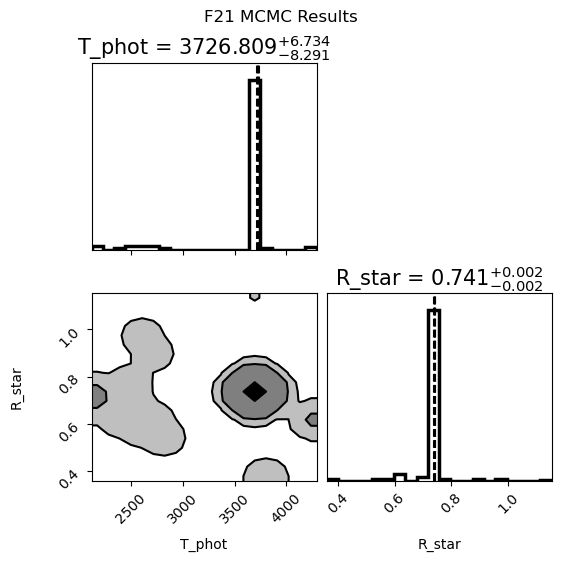

T_phot:
  Median (50th percentile): 3726.81
  Lower 1-sigma uncertainty: 8.3
  Upper 1-sigma uncertainty: 6.8

R_star:
  Median (50th percentile): 0.74
  Lower 1-sigma uncertainty: 0.002
  Upper 1-sigma uncertainty: 0.002
Combined Chi-squared: 908.98
Combined Reduced Chi-squared: 4.17
Combined Degrees of Freedom: 218


Processing S22 (both directions)

Minimization Results for S22:
T_phot: Value = 3702.95, 1-sigma = 5.732531799016524
R_star: Value = 0.77, 1-sigma = 0.0020929877909774204
Chi-squared: 1686.93
Reduced Chi-squared: 6.75
Degrees of freedom: 250

Running MCMC sampler...


100%|██████████| 1000/1000 [03:27<00:00,  4.81it/s]


(Nsteps-burnin)*nwalkers/tau= [99.41883867]
(Nsteps-burnin)*nwalkers/tau= [103.00310121]


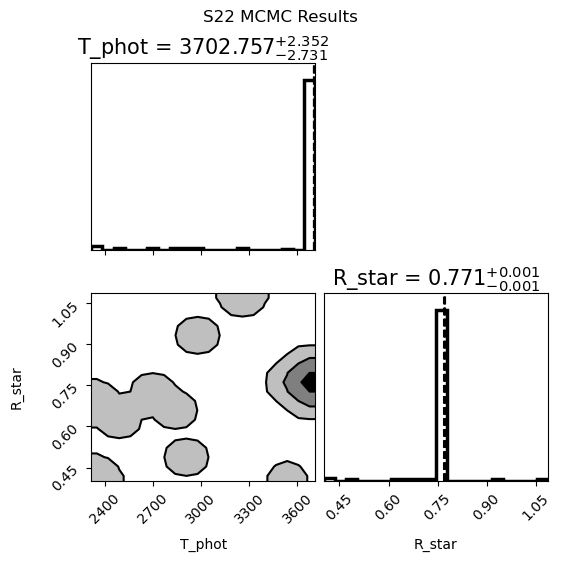

T_phot:
  Median (50th percentile): 3702.76
  Lower 1-sigma uncertainty: 2.7
  Upper 1-sigma uncertainty: 2.4

R_star:
  Median (50th percentile): 0.77
  Lower 1-sigma uncertainty: 0.001
  Upper 1-sigma uncertainty: 0.001
Combined Chi-squared: 1688.28
Combined Reduced Chi-squared: 6.75
Combined Degrees of Freedom: 250




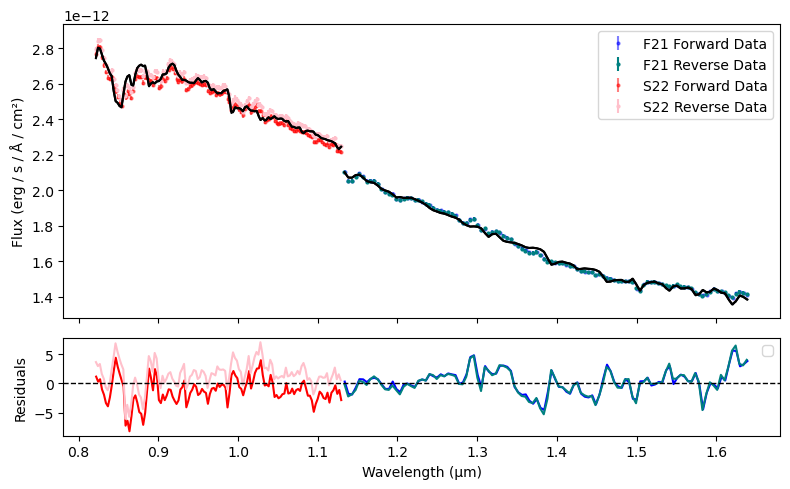

In [36]:
def residual(parameters, data_wave_1, data_flux_1, data_err_1, data_wave_2, data_flux_2, data_err_2):
    
    _model = spectral_model(parameters, filter_sigma)
    
    # Bin the model to the first data wavelengths
    binned_model_1 = bintogrid(model_wavelengths.value, _model, newx=data_wave_1.value)
    model_flux_1 = binned_model_1['y'] * u.erg / u.s / u.angstrom / u.cm / u.cm
    
    # Bin the model to the second data wavelengths
    binned_model_2 = bintogrid(model_wavelengths.value, _model, newx=data_wave_2.value)
    model_flux_2 = binned_model_2['y'] * u.erg / u.s / u.angstrom / u.cm / u.cm
    
    # Calculate residuals for both directions
    residual_1 = (data_flux_1 - model_flux_1) / data_err_1
    residual_2 = (data_flux_2 - model_flux_2) / data_err_2
    
    # Combine the residuals
    combined_residual = np.concatenate([residual_1, residual_2])
    
    return combined_residual

# Define the log-probability function to include both scan directions
def log_probability(parameters, data_wave_1, data_flux_1, data_err_1,
                    data_wave_2, data_flux_2, data_err_2):
    # Unpack parameters
    T_phot, R_star = parameters
    log_likelihood = 0
    
    # Boundary conditions for parameters to ensure physical validity
    if not (3400 <= T_phot <= 5000 and 0.6 <= R_star <= 0.9):
        return -np.inf  # Return log-probability of -inf outside bounds

    # Set parameters in lmfit
    model_params = lmfit.Parameters()
    model_params.add('T_phot', value=T_phot)
    model_params.add('R_star', value=R_star)

    # Generate model based on these parameters for both scan directions
    model_flux_1 = bintogrid(model_wavelengths.value, spectral_model(model_params, filter_sigma), newx=data_wave_1.value)['y']
    model_flux_2 = bintogrid(model_wavelengths.value, spectral_model(model_params, filter_sigma), newx=data_wave_2.value)['y']
    
    # Calculate residuals and log-likelihood for both directions
    residuals_1 = data_flux_1.value - model_flux_1
    residuals_2 = data_flux_2.value - model_flux_2
    
    ln_like_1 = -0.5 * np.nansum((residuals_1 / data_err_1.value) ** 2)
    ln_like_2 = -0.5 * np.nansum((residuals_2 / data_err_2.value) ** 2)
    
    log_likelihood += (ln_like_1 + ln_like_2)
    
    return log_likelihood

# Collect all visit data for plotting
all_data = {
    'visit': [],
    'direction': [],
    'wavelength': [],
    'calibrated_flux': [],
    'calibrated_flux_err': [],
    'model_flux': [],
    'residuals': [],
    'samples': []
}
results_table = []

"""
SET PARAMETERS FOR LABELS AND FILESAVING
"""
ncomponents = 1
speclibrary = 'sphinx'
spectral_model = sphinx_1T
nwalkers = 100
nsteps = 1000

# Modify the loop to process both directions together
for visit in ['F21', 'S22']:

    print(f"Processing {visit} (both directions)\n")
    data_wave_list = []
    data_flux_list = []
    data_err_list = []
    
    # Prepare data for both directions
    exptime = visits[f'{visit}']['exp (s)']
    binwidth = visits[f'{visit}']['native resolution']
    grism = visits[f'{visit}']['Grism']
    if visit=='F21':
        filter_sigma = 5.0 * u.pixel
    if visit=='S22':
        filter_sigma = 2.5 * u.pixel

    trimmed_r_fwd = read_rainbow(f"../data/{visit}_Forward_trimmed_pacman_spec.rainbow.npy")
    trimmed_r_rev = read_rainbow(f"../data/{visit}_Reverse_trimmed_pacman_spec.rainbow.npy")
    
    # Process forward direction data
    median_spectrum_fwd = trimmed_r_fwd.get_median_spectrum().value
    e_per_s_fwd = median_spectrum_fwd / exptime
    e_per_s_per_angstrom_fwd = e_per_s_fwd / binwidth
    w_fwd, s_fwd, e_fwd = read_sensitivity_curve(grism=grism)
    binned_filter_response_fwd = bintogrid(w_fwd.value, s_fwd.value, newx=trimmed_r_fwd.wavelength.value)['y'] * u.cm**2 / u.erg
    calibrated_data_flux_fwd = e_per_s_per_angstrom_fwd / binned_filter_response_fwd
    calibrated_flux_err_fwd = 0.005 * calibrated_data_flux_fwd

    # Append forward direction data to the lists
    data_wave_list.append(trimmed_r_fwd.wavelength)
    data_flux_list.append(calibrated_data_flux_fwd)
    data_err_list.append(calibrated_flux_err_fwd)

    # Process reverse direction data
    median_spectrum_rev = trimmed_r_rev.get_median_spectrum().value
    e_per_s_rev = median_spectrum_rev / exptime
    e_per_s_per_angstrom_rev = e_per_s_rev / binwidth
    w_rev, s_rev, e_rev = read_sensitivity_curve(grism=grism)
    binned_filter_response_rev = bintogrid(w_rev.value, s_rev.value, newx=trimmed_r_rev.wavelength.value)['y'] * u.cm**2 / u.erg
    calibrated_data_flux_rev = e_per_s_per_angstrom_rev / binned_filter_response_rev
    calibrated_flux_err_rev = 0.005 * calibrated_data_flux_rev

    # Append reverse direction data to the lists
    data_wave_list.append(trimmed_r_rev.wavelength)
    data_flux_list.append(calibrated_data_flux_rev)
    data_err_list.append(calibrated_flux_err_rev)

    # Set up lmfit parameters
    parameters = lmfit.Parameters()
    parameters.add('T_phot', value=4000, min=3400, max=5000, vary=True)
    parameters.add('R_star', value=0.78, min=0.6, max=0.9, vary=True)

    # Run the lmfit minimizer for both directions together
    result = lmfit.minimize(
        residual, 
        parameters, 
        args=(data_wave_list[0], data_flux_list[0], data_err_list[0],
        data_wave_list[1], data_flux_list[1], data_err_list[1])
    )
    
    # Print and log the results as previously done.
    
    print(f"Minimization Results for {visit}:")
    for param_name, param in result.params.items():
        print(f"{param_name}: Value = {param.value:.2f}, 1-sigma = {param.stderr if param.stderr else 'N/A'}")
    
    chi_squared = result.chisqr
    reduced_chi_squared = result.redchi
    dof = result.nfree  # Degrees of freedom
    print(f"Chi-squared: {chi_squared:.2f}")
    print(f"Reduced Chi-squared: {reduced_chi_squared:.2f}")
    print(f"Degrees of freedom: {dof}\n")

    # Append minimization results to the table
    results_entry = {
        'Visit': visit,
        'Chi-squared': chi_squared,
        'Reduced Chi-squared': reduced_chi_squared
    }
    
    for param_name, param in result.params.items():
        results_entry[f'{param_name} (Value)'] = param.value
        results_entry[f'{param_name} (1-sigma)'] = param.stderr if param.stderr else 'N/A'
    results_table.append(results_entry)

    # Store data for plotting for the forward scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Forward')
    all_data['wavelength'].append(trimmed_r_fwd.wavelength.value)
    all_data['calibrated_flux'].append(calibrated_data_flux_fwd.value)
    all_data['calibrated_flux_err'].append(calibrated_flux_err_fwd.value)
    
    # Store data for plotting for the reverse scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Reverse')
    all_data['wavelength'].append(trimmed_r_rev.wavelength.value)
    all_data['calibrated_flux'].append(calibrated_data_flux_rev.value)
    all_data['calibrated_flux_err'].append(calibrated_flux_err_rev.value)

    # MCMC setup
    ndim = len(result.params)
    burnin = int(0.5*nsteps)
    initial_pos = [
        np.array([
            np.random.normal(result.params[name].value, 0.2 * result.params[name].value)
            for name in result.params])
        for _ in range(nwalkers)]
    label=f'{visit}_{nsteps}steps_{ncomponents}T_{speclibrary}_specmodel'
    samples_fname = f"../data/samples/{label}.h5"
    backend = emcee.backends.HDFBackend(samples_fname)
    backend.reset(nwalkers, ndim)        
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, 
        args=(data_wave_list[0], data_flux_list[0], data_err_list[0],
        data_wave_list[1], data_flux_list[1], data_err_list[1]), 
        backend=backend)

    # Run the MCMC sampler
    print('Running MCMC sampler...')
    sampler.run_mcmc(initial_pos, nsteps, store=True, progress=True)
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
    all_data['samples'].append(samples)

    # Check for convergence (all should be > 100)
    for i in range(len(samples)):
        tau_f = emcee.autocorr.integrated_time(samples[i])
        print('(Nsteps-burnin)*nwalkers/tau=',(nsteps-burnin)*nwalkers/tau_f)
    
    # Make corner plot
    rng = 0.9995
    fig = corner.corner( 
        samples.T,show_titles=True, labels=['T_phot', 'R_star'],
        range=[rng]*ndim,smooth=1,quantiles=(0.16, 0.5, 0.84),
        fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 15},title_fmt='.3f',
        hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
    )
    plt.suptitle(f"{visit} MCMC Results")
    plt.savefig(f'../figs/{visit}_{nsteps}nsteps_{ncomponents}T_{speclibrary}_specmodel_corner.png')
    plt.show()

    # Calculate best-fit model flux from MCMC results
    T_phot_sam, R_star_sam = samples
    sig1_T_phot = np.percentile(T_phot_sam, [15.9, 50., 84.1]) # central 1-sigma values
    sig1_R_star = np.percentile(R_star_sam, [15.9, 50., 84.1])
    
    # Print the 50th percentile (median) and 1-sigma uncertainties for each parameter
    print("T_phot:")
    print(f"  Median (50th percentile): {sig1_T_phot[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_T_phot[1] - sig1_T_phot[0]:.1f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_T_phot[2] - sig1_T_phot[1]:.1f}")
    print("\nR_star:")
    print(f"  Median (50th percentile): {sig1_R_star[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_R_star[1] - sig1_R_star[0]:.3f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_R_star[2] - sig1_R_star[1]:.3f}")
    
    # Set parameters in lmfit
    mcmc_model_params = lmfit.Parameters()
    mcmc_model_params.add('T_phot', value=sig1_T_phot[1])
    mcmc_model_params.add('R_star', value=sig1_R_star[1])

    # Calculate the max likelihood model for both scan directions
    best_model = spectral_model(mcmc_model_params, filter_sigma)
    
    # Generate binned model fluxes for both scan directions
    model_flux_mcmc_fwd = bintogrid(model_wavelengths.value, best_model, newx=trimmed_r_fwd.wavelength.value)['y']
    model_flux_mcmc_rev = bintogrid(model_wavelengths.value, best_model, newx=trimmed_r_rev.wavelength.value)['y']
    
    # Calculate residuals for both scan directions
    residuals_fwd = calibrated_data_flux_fwd.value - model_flux_mcmc_fwd
    residuals_rev = calibrated_data_flux_rev.value - model_flux_mcmc_rev
    
    # Append residuals for plotting
    all_data['model_flux'].append(model_flux_mcmc_fwd)
    all_data['model_flux'].append(model_flux_mcmc_rev)
    all_data['residuals'].append(residuals_fwd)
    all_data['residuals'].append(residuals_rev)
    
    # Calculate combined chi-squared and reduced chi-squared
    combined_residuals = np.concatenate([
        residuals_fwd / calibrated_flux_err_fwd.value,
        residuals_rev / calibrated_flux_err_rev.value
    ])
    chisq_combined = np.nansum(combined_residuals ** 2)
    total_data_points = len(calibrated_data_flux_fwd) + len(calibrated_data_flux_rev)
    dof_combined = total_data_points - len(mcmc_model_params)
    
    # Calculate reduced chi-squared
    reduced_chisq_combined = chisq_combined / dof_combined
    
    # Print combined chi-squared statistics
    print(f"Combined Chi-squared: {chisq_combined:.2f}")
    print(f"Combined Reduced Chi-squared: {reduced_chisq_combined:.2f}")
    print(f"Combined Degrees of Freedom: {dof_combined}")
    print("\n")

# Plot all data, models, and residuals on a single plot
fig, (ax, ax_residuals) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 5), sharex=True)
colors = ['blue', 'teal', 'red', 'pink']
alphas = [0.5, 1.0, 0.5, 1.0]

for i, (visit, direction, wavelength, data_flux, data_err, model_flux, residual) in enumerate(zip(
    all_data['visit'], all_data['direction'], all_data['wavelength'], all_data['calibrated_flux'], 
    all_data['calibrated_flux_err'], all_data['model_flux'], all_data['residuals'])):
    
    color = colors[i % len(colors)]
    ax.errorbar(wavelength, data_flux, yerr=data_err, fmt='o', color=color, ms=2, label=f'{visit} {direction} Data', alpha=alphas[i])
    ax.plot(wavelength, model_flux, color='k',zorder=1000)
    ax_residuals.plot(wavelength, residual / data_err, color=color)

# Plot configuration
ax.set_ylabel('Flux (erg / s / Å / cm²)')
ax.legend()
ax_residuals.axhline(0, color='black', linestyle='--', linewidth=1)
ax_residuals.set_ylabel('Residuals')
ax_residuals.set_xlabel('Wavelength (μm)')
ax_residuals.legend()

plt.tight_layout()
plt.savefig(f'../figs/{ncomponents}T_{speclibrary}_spectral_resultsplot.png')
plt.show()

# 2T Phoenix Modeling

In [ ]:
def residual(parameters, data_wave_1, data_flux_1, data_err_1, data_wave_2, data_flux_2, data_err_2):
    
    _model = spectral_model(parameters, filter_sigma)
    
    # Bin the model to the first data wavelengths
    binned_model_1 = bintogrid(model_wavelengths.value, _model, newx=data_wave_1.value)
    model_flux_1 = binned_model_1['y'] * u.erg / u.s / u.angstrom / u.cm / u.cm
    
    # Bin the model to the second data wavelengths
    binned_model_2 = bintogrid(model_wavelengths.value, _model, newx=data_wave_2.value)
    model_flux_2 = binned_model_2['y'] * u.erg / u.s / u.angstrom / u.cm / u.cm
    
    # Calculate residuals for both directions
    residual_1 = (data_flux_1 - model_flux_1) / data_err_1
    residual_2 = (data_flux_2 - model_flux_2) / data_err_2
    
    # Combine the residuals
    combined_residual = np.concatenate([residual_1, residual_2])
    
    return combined_residual

# Define the log-probability function to include both scan directions
def log_probability(parameters, data_wave_1, data_flux_1, data_err_1,
                    data_wave_2, data_flux_2, data_err_2):
    
    logg_spot, f_cool, T_cool, T_phot, R_star = parameters
    log_likelihood = 0
    
    # Boundary conditions for parameters to ensure physical validity
    if not (2.0 <= logg_spot <= 4.52 and 0.05<=f_cool<=0.95 and 2300 <= T_cool <= T_phot <= 5000 and 0.6 <= R_star <= 0.9):
        return -np.inf  # Return log-probability of -inf outside bounds

    # Set parameters in lmfit
    model_params = lmfit.Parameters()
    model_params.add('logg_spot', value=logg_spot)
    model_params.add('f_cool', value=f_cool)
    model_params.add('T_cool', value=T_cool)
    model_params.add('T_phot', value=T_phot)
    model_params.add('R_star', value=R_star)

    # Generate model based on these parameters for both scan directions
    model_flux_1 = bintogrid(model_wavelengths.value, spectral_model(model_params, filter_sigma), newx=data_wave_1.value)['y']
    model_flux_2 = bintogrid(model_wavelengths.value, spectral_model(model_params, filter_sigma), newx=data_wave_2.value)['y']
    
    # Calculate residuals and log-likelihood for both directions
    residuals_1 = data_flux_1.value - model_flux_1
    residuals_2 = data_flux_2.value - model_flux_2
    
    ln_like_1 = -0.5 * np.nansum((residuals_1 / data_err_1.value) ** 2)
    ln_like_2 = -0.5 * np.nansum((residuals_2 / data_err_2.value) ** 2)
    
    log_likelihood += (ln_like_1 + ln_like_2)
    
    return log_likelihood

# Collect all visit data for plotting
all_data = {
    'visit': [],
    'direction': [],
    'wavelength': [],
    'calibrated_flux': [],
    'calibrated_flux_err': [],
    'model_flux': [],
    'residuals': [],
    'samples': []
}
results_table = []

"""
SET PARAMETERS FOR LABELS AND FILESAVING
"""
ncomponents = 2
speclibrary = 'phoenix'
spectral_model = phoenix_2T
nwalkers = 150
nsteps = 10000

# Modify the loop to process both directions together
for visit in ['F21', 'S22']:

    print(f"Processing {visit} (both directions)\n")
    data_wave_list = []
    data_flux_list = []
    data_err_list = []
    
    # Prepare data for both directions
    exptime = visits[f'{visit}']['exp (s)']
    binwidth = visits[f'{visit}']['native resolution']
    grism = visits[f'{visit}']['Grism']
    if visit=='F21':
        filter_sigma = 5.0 * u.pixel
    if visit=='S22':
        filter_sigma = 2.5 * u.pixel
        
    trimmed_r_fwd = read_rainbow(f"../data/{visit}_Forward_trimmed_pacman_spec.rainbow.npy")
    trimmed_r_rev = read_rainbow(f"../data/{visit}_Reverse_trimmed_pacman_spec.rainbow.npy")
    
    # Process forward direction data
    median_spectrum_fwd = trimmed_r_fwd.get_median_spectrum().value
    e_per_s_fwd = median_spectrum_fwd / exptime
    e_per_s_per_angstrom_fwd = e_per_s_fwd / binwidth
    w_fwd, s_fwd, e_fwd = read_sensitivity_curve(grism=grism)
    binned_filter_response_fwd = bintogrid(w_fwd.value, s_fwd.value, newx=trimmed_r_fwd.wavelength.value)['y'] * u.cm**2 / u.erg
    calibrated_data_flux_fwd = e_per_s_per_angstrom_fwd / binned_filter_response_fwd
    calibrated_flux_err_fwd = 0.005 * calibrated_data_flux_fwd

    # Append forward direction data to the lists
    data_wave_list.append(trimmed_r_fwd.wavelength)
    data_flux_list.append(calibrated_data_flux_fwd)
    data_err_list.append(calibrated_flux_err_fwd)

    # Process reverse direction data
    median_spectrum_rev = trimmed_r_rev.get_median_spectrum().value
    e_per_s_rev = median_spectrum_rev / exptime
    e_per_s_per_angstrom_rev = e_per_s_rev / binwidth
    w_rev, s_rev, e_rev = read_sensitivity_curve(grism=grism)
    binned_filter_response_rev = bintogrid(w_rev.value, s_rev.value, newx=trimmed_r_rev.wavelength.value)['y'] * u.cm**2 / u.erg
    calibrated_data_flux_rev = e_per_s_per_angstrom_rev / binned_filter_response_rev
    calibrated_flux_err_rev = 0.005 * calibrated_data_flux_rev

    # Append reverse direction data to the lists
    data_wave_list.append(trimmed_r_rev.wavelength)
    data_flux_list.append(calibrated_data_flux_rev)
    data_err_list.append(calibrated_flux_err_rev)

    # Set up lmfit parameters
    parameters = lmfit.Parameters()
    parameters.add('logg_spot', value=4.5, min=2.0, max=4.52, vary=True)
    parameters.add('f_cool', value=0.4, min=0.05, max=0.95, vary=True)
    parameters.add('T_cool', value=3000, min=2300, max=3700, vary=True)
    parameters.add('T_phot', value=4000, min=3500, max=5000, vary=True)
    parameters.add('R_star', value=0.78, min=0.6, max=0.9, vary=True)

    # Run the lmfit minimizer for both directions together
    result = lmfit.minimize(
        residual, 
        parameters, 
        args=(data_wave_list[0], data_flux_list[0], data_err_list[0],
        data_wave_list[1], data_flux_list[1], data_err_list[1])
    )
    
    # Print and log the results as previously done.
    
    print(f"Minimization Results for {visit}:")
    for param_name, param in result.params.items():
        print(f"{param_name}: Value = {param.value:.2f}, 1-sigma = {param.stderr if param.stderr else 'N/A'}")
    
    chi_squared = result.chisqr
    reduced_chi_squared = result.redchi
    dof = result.nfree  # Degrees of freedom
    print(f"Chi-squared: {chi_squared:.2f}")
    print(f"Reduced Chi-squared: {reduced_chi_squared:.2f}")
    print(f"Degrees of freedom: {dof}\n")

    # Append minimization results to the table
    results_entry = {
        'Visit': visit,
        'Chi-squared': chi_squared,
        'Reduced Chi-squared': reduced_chi_squared
    }
    
    for param_name, param in result.params.items():
        results_entry[f'{param_name} (Value)'] = param.value
        results_entry[f'{param_name} (1-sigma)'] = param.stderr if param.stderr else 'N/A'
    results_table.append(results_entry)

    # Store data for plotting for the forward scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Forward')
    all_data['wavelength'].append(trimmed_r_fwd.wavelength.value)
    all_data['calibrated_flux'].append(calibrated_data_flux_fwd.value)
    all_data['calibrated_flux_err'].append(calibrated_flux_err_fwd.value)
    
    # Store data for plotting for the reverse scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Reverse')
    all_data['wavelength'].append(trimmed_r_rev.wavelength.value)
    all_data['calibrated_flux'].append(calibrated_data_flux_rev.value)
    all_data['calibrated_flux_err'].append(calibrated_flux_err_rev.value)

    # MCMC setup
    ndim = len(result.params)
    burnin = int(0.5*nsteps)
    initial_pos = [
        np.array([
            np.random.normal(result.params[name].value, 0.2 * result.params[name].value)
            for name in result.params])
        for _ in range(nwalkers)]
    label=f'{visit}_{nsteps}steps_{ncomponents}T_{speclibrary}_specmodel'
    samples_fname = f"../data/samples/{label}.h5"
    backend = emcee.backends.HDFBackend(samples_fname)
    backend.reset(nwalkers, ndim)        
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, 
        args=(data_wave_list[0], data_flux_list[0], data_err_list[0],
        data_wave_list[1], data_flux_list[1], data_err_list[1]), 
        backend=backend)

    # Run the MCMC sampler
    print('Running MCMC sampler...')
    sampler.run_mcmc(initial_pos, nsteps, store=True, progress=True)
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
    all_data['samples'].append(samples)

    # Check for convergence (all should be > 100)
    for i in range(len(samples)):
        tau_f = emcee.autocorr.integrated_time(samples[i])
        print('(Nsteps-burnin)*nwalkers/tau=',(nsteps-burnin)*nwalkers/tau_f)
    
    # Make corner plot
    rng = 0.9995
    fig = corner.corner( 
        samples.T,show_titles=True, labels=['logg_spot', 'f_cool', 'T_cool', 'T_phot', 'R_star'],
        range=[rng]*ndim,smooth=1,quantiles=(0.16, 0.5, 0.84),
        fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 15},title_fmt='.3f',
        hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
    )
    plt.suptitle(f"{visit} MCMC Results")
    plt.savefig(f'../figs/{visit}_{nsteps}nsteps_{ncomponents}T_{speclibrary}_specmodel_corner.png')
    plt.show()

    # Calculate best-fit model flux from MCMC results
    logg_spot_sam, f_cool_sam, T_cool_sam, T_phot_sam, R_star_sam = samples
    sig1_logg_spot = np.percentile(logg_spot_sam, [15.9, 50., 84.1]) # central 1-sigma values
    sig1_f_cool = np.percentile(f_cool_sam, [15.9, 50., 84.1]) # central 1-sigma values
    sig1_T_cool = np.percentile(T_cool_sam, [15.9, 50., 84.1]) # central 1-sigma values
    sig1_T_phot = np.percentile(T_phot_sam, [15.9, 50., 84.1]) # central 1-sigma values
    sig1_R_star = np.percentile(R_star_sam, [15.9, 50., 84.1])
    
    # Print the 50th percentile (median) and 1-sigma uncertainties for each parameter
    print("logg_spot:")
    print(f"  Median (50th percentile): {sig1_logg_spot[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_logg_spot[1] - sig1_logg_spot[0]:.2f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_logg_spot[2] - sig1_logg_spot[1]:.2f}")
    print("\nf_cool:")
    print(f"  Median (50th percentile): {sig1_f_cool[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_f_cool[1] - sig1_f_cool[0]:.2f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_f_cool[2] - sig1_f_cool[1]:.2f}")
    print("\nT_cool:")
    print(f"  Median (50th percentile): {sig1_T_cool[1]:.1f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_T_cool[1] - sig1_T_cool[0]:.1f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_T_cool[2] - sig1_T_cool[1]:.1f}")
    print("\nT_phot:")
    print(f"  Median (50th percentile): {sig1_T_phot[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_T_phot[1] - sig1_T_phot[0]:.1f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_T_phot[2] - sig1_T_phot[1]:.1f}")
    print("\nR_star:")
    print(f"  Median (50th percentile): {sig1_R_star[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_R_star[1] - sig1_R_star[0]:.3f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_R_star[2] - sig1_R_star[1]:.3f}")
    
    # Set parameters in lmfit
    mcmc_model_params = lmfit.Parameters()
    mcmc_model_params.add('logg_spot', value=sig1_logg_spot[1])
    mcmc_model_params.add('f_cool', value=sig1_f_cool[1])
    mcmc_model_params.add('T_cool', value=sig1_T_cool[1])
    mcmc_model_params.add('T_phot', value=sig1_T_phot[1])
    mcmc_model_params.add('R_star', value=sig1_R_star[1])

    # Calculate the max likelihood model for both scan directions
    best_model = spectral_model(mcmc_model_params, filter_sigma)
    
    # Generate binned model fluxes for both scan directions
    model_flux_mcmc_fwd = bintogrid(model_wavelengths.value, best_model, newx=trimmed_r_fwd.wavelength.value)['y']
    model_flux_mcmc_rev = bintogrid(model_wavelengths.value, best_model, newx=trimmed_r_rev.wavelength.value)['y']
    
    # Calculate residuals for both scan directions
    residuals_fwd = calibrated_data_flux_fwd.value - model_flux_mcmc_fwd
    residuals_rev = calibrated_data_flux_rev.value - model_flux_mcmc_rev
    
    # Append residuals for plotting
    all_data['model_flux'].append(model_flux_mcmc_fwd)
    all_data['model_flux'].append(model_flux_mcmc_rev)
    all_data['residuals'].append(residuals_fwd)
    all_data['residuals'].append(residuals_rev)
    
    # Calculate combined chi-squared and reduced chi-squared
    combined_residuals = np.concatenate([
        residuals_fwd / calibrated_flux_err_fwd.value,
        residuals_rev / calibrated_flux_err_rev.value
    ])
    chisq_combined = np.nansum(combined_residuals ** 2)
    total_data_points = len(calibrated_data_flux_fwd) + len(calibrated_data_flux_rev)
    dof_combined = total_data_points - len(mcmc_model_params)
    
    # Calculate reduced chi-squared
    reduced_chisq_combined = chisq_combined / dof_combined
    
    # Print combined chi-squared statistics
    print(f"Combined Chi-squared: {chisq_combined:.2f}")
    print(f"Combined Reduced Chi-squared: {reduced_chisq_combined:.2f}")
    print(f"Combined Degrees of Freedom: {dof_combined}")
    print("\n")

Processing F21 (both directions)

Minimization Results for F21:
logg_spot: Value = 3.50, 1-sigma = 0.8661029198665456
f_cool: Value = 0.33, 1-sigma = 0.032753901618209916
T_cool: Value = 2730.78, 1-sigma = 63.925493673317796
T_phot: Value = 4036.98, 1-sigma = 40.5284570162079
R_star: Value = 0.75, 1-sigma = 0.015184334463515026
Chi-squared: 476.24
Reduced Chi-squared: 2.22
Degrees of freedom: 215

Running MCMC sampler...


 14%|█▍        | 1441/10000 [10:40<1:08:22,  2.09it/s]

In [ ]:
#### Plot all data, models, and residuals on a single plot
fig, (ax, ax_residuals) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 5), sharex=True)
colors = ['blue', 'teal', 'red', 'pink']
alphas = [0.5, 1.0, 0.5, 1.0]

for i, (visit, direction, wavelength, data_flux, data_err, model_flux, residual) in enumerate(zip(
    all_data['visit'], all_data['direction'], all_data['wavelength'], all_data['calibrated_flux'], 
    all_data['calibrated_flux_err'], all_data['model_flux'], all_data['residuals'])):
    
    color = colors[i % len(colors)]
    ax.errorbar(wavelength, data_flux, yerr=data_err, fmt='o', color=color, ms=2, label=f'{visit} {direction} Data', alpha=alphas[i])
    ax.plot(wavelength, model_flux, color='k',zorder=1000)
    ax_residuals.plot(wavelength, residual / data_err, color=color)

# Plot configuration
ax.set_ylabel('Flux (erg / s / Å / cm²)')
ax.legend()
ax_residuals.axhline(0, color='black', linestyle='--', linewidth=1)
ax_residuals.set_ylabel('Residuals')
ax_residuals.set_xlabel('Wavelength (μm)')
ax_residuals.legend()

plt.tight_layout()
plt.savefig(f'../figs/{ncomponents}T_{speclibrary}_spectral_resultsplot.png')
plt.show()

# 3T BT-SETTL Modeling

In [ ]:
def residual(parameters, data_wave_1, data_flux_1, data_err_1, data_wave_2, data_flux_2, data_err_2):
    
    _model = spectral_model(parameters, filter_sigma)
    
    # Bin the model to the first data wavelengths
    binned_model_1 = bintogrid(model_wavelengths.value, _model, newx=data_wave_1.value)
    model_flux_1 = binned_model_1['y'] * u.erg / u.s / u.angstrom / u.cm / u.cm
    
    # Bin the model to the second data wavelengths
    binned_model_2 = bintogrid(model_wavelengths.value, _model, newx=data_wave_2.value)
    model_flux_2 = binned_model_2['y'] * u.erg / u.s / u.angstrom / u.cm / u.cm
    
    # Calculate residuals for both directions
    residual_1 = (data_flux_1 - model_flux_1) / data_err_1
    residual_2 = (data_flux_2 - model_flux_2) / data_err_2
    
    # Combine the residuals
    combined_residual = np.concatenate([residual_1, residual_2])
    
    return combined_residual

# Define the log-probability function to include both scan directions
def log_probability(parameters, data_wave_1, data_flux_1, data_err_1,
                    data_wave_2, data_flux_2, data_err_2):
    
    logg_spot, f_cool, T_cool, f_phot, T_phot, logg_other, T_other, R_star = parameters
    log_likelihood = 0

    c1 = (0.05<=f_cool<=0.95)
    c2 = (2300 <= T_cool <= T_phot <= 5000)
    c3 = (0.6 <= R_star <= 0.9)
    c4 = (0.0<=f_phot<=(1.0-f_cool))
    c5 = (2300 <= T_other <= 10000)
    c6 = 2.0<= logg_spot <= 4.52
    c7 = 2.0<= logg_other <= 4.52
    # Boundary conditions for parameters to ensure physical validity
    if not (c1 and c2 and c3 and c4 and c5 and c6 and c7):
        return -np.inf  # Return log-probability of -inf outside bounds

    # Set parameters in lmfit
    model_params = lmfit.Parameters()
    model_params.add('logg_spot', value=logg_spot)
    model_params.add('f_cool', value=f_cool)
    model_params.add('T_cool', value=T_cool)
    model_params.add('f_phot', value=f_phot)
    model_params.add('T_phot', value=T_phot)
    model_params.add('logg_other', value=logg_other)
    model_params.add('T_other', value=T_other)
    model_params.add('R_star', value=R_star)

    # Generate model based on these parameters for both scan directions
    model_flux_1 = bintogrid(model_wavelengths.value, spectral_model(model_params, filter_sigma), newx=data_wave_1.value)['y']
    model_flux_2 = bintogrid(model_wavelengths.value, spectral_model(model_params, filter_sigma), newx=data_wave_2.value)['y']
    
    # Calculate residuals and log-likelihood for both directions
    residuals_1 = data_flux_1.value - model_flux_1
    residuals_2 = data_flux_2.value - model_flux_2
    
    ln_like_1 = -0.5 * np.nansum((residuals_1 / data_err_1.value) ** 2)
    ln_like_2 = -0.5 * np.nansum((residuals_2 / data_err_2.value) ** 2)
    
    log_likelihood += (ln_like_1 + ln_like_2)
    
    return log_likelihood

# Collect all visit data for plotting
all_data = {
    'visit': [],
    'direction': [],
    'wavelength': [],
    'calibrated_flux': [],
    'calibrated_flux_err': [],
    'model_flux': [],
    'residuals': [],
    'samples': []
}
results_table = []

"""
SET PARAMETERS FOR LABELS AND FILESAVING
"""
ncomponents = 3
speclibrary = 'btsettl'

spectral_model = btsettl_3T
nwalkers = 200
nsteps = 20000

# Modify the loop to process both directions together
for visit in ['F21', 'S22']:

    print(f"Processing {visit} (both directions)\n")
    data_wave_list = []
    data_flux_list = []
    data_err_list = []
    
    # Prepare data for both directions
    exptime = visits[f'{visit}']['exp (s)']
    binwidth = visits[f'{visit}']['native resolution']
    grism = visits[f'{visit}']['Grism']
    filter_sigma = visits[f'{visit}']['filter_sigma']

    trimmed_r_fwd = read_rainbow(f"../data/{visit}_Forward_trimmed_pacman_spec.rainbow.npy")
    trimmed_r_rev = read_rainbow(f"../data/{visit}_Reverse_trimmed_pacman_spec.rainbow.npy")
    
    # Process forward direction data
    median_spectrum_fwd = trimmed_r_fwd.get_median_spectrum().value
    e_per_s_fwd = median_spectrum_fwd / exptime
    e_per_s_per_angstrom_fwd = e_per_s_fwd / binwidth
    w_fwd, s_fwd, e_fwd = read_sensitivity_curve(grism=grism)
    binned_filter_response_fwd = bintogrid(w_fwd.value, s_fwd.value, newx=trimmed_r_fwd.wavelength.value)['y'] * u.cm**2 / u.erg
    calibrated_data_flux_fwd = e_per_s_per_angstrom_fwd / binned_filter_response_fwd
    calibrated_flux_err_fwd = 0.005 * calibrated_data_flux_fwd

    # Append forward direction data to the lists
    data_wave_list.append(trimmed_r_fwd.wavelength)
    data_flux_list.append(calibrated_data_flux_fwd)
    data_err_list.append(calibrated_flux_err_fwd)

    # Process reverse direction data
    median_spectrum_rev = trimmed_r_rev.get_median_spectrum().value
    e_per_s_rev = median_spectrum_rev / exptime
    e_per_s_per_angstrom_rev = e_per_s_rev / binwidth
    w_rev, s_rev, e_rev = read_sensitivity_curve(grism=grism)
    binned_filter_response_rev = bintogrid(w_rev.value, s_rev.value, newx=trimmed_r_rev.wavelength.value)['y'] * u.cm**2 / u.erg
    calibrated_data_flux_rev = e_per_s_per_angstrom_rev / binned_filter_response_rev
    calibrated_flux_err_rev = 0.005 * calibrated_data_flux_rev

    # Append reverse direction data to the lists
    data_wave_list.append(trimmed_r_rev.wavelength)
    data_flux_list.append(calibrated_data_flux_rev)
    data_err_list.append(calibrated_flux_err_rev)

    # Set up lmfit parameters
    parameters = lmfit.Parameters()
    parameters.add('logg_spot', value=4.5, min=2.0, max=4.52, vary=True)
    parameters.add('f_cool', value=0.3, min=0.05, max=0.95, vary=True)
    parameters.add('T_cool', value=3000, min=2300, max=3700, vary=True)
    parameters.add('f_phot', value=0.6, min=0.2, max=0.95, vary=True)
    parameters.add('T_phot', value=4000, min=3500, max=5000, vary=True)
    parameters.add('logg_other', value=4.5, min=2.0, max=4.52, vary=True)
    parameters.add('T_other', value=3700, min=2300, max=10000, vary=True)
    parameters.add('R_star', value=0.78, min=0.6, max=0.90, vary=True)

    # Run the lmfit minimizer for both directions together
    result = lmfit.minimize(
        residual, 
        parameters, 
        args=(data_wave_list[0], data_flux_list[0], data_err_list[0],
        data_wave_list[1], data_flux_list[1], data_err_list[1])
    )
    
    # Print and log the results as previously done.
    
    print(f"Minimization Results for {visit}:")
    for param_name, param in result.params.items():
        print(f"{param_name}: Value = {param.value:.2f}, 1-sigma = {param.stderr if param.stderr else 'N/A'}")
    
    chi_squared = result.chisqr
    reduced_chi_squared = result.redchi
    dof = result.nfree  # Degrees of freedom
    print(f"Chi-squared: {chi_squared:.2f}")
    print(f"Reduced Chi-squared: {reduced_chi_squared:.2f}")
    print(f"Degrees of freedom: {dof}\n")

    # Append minimization results to the table
    results_entry = {
        'Visit': visit,
        'Chi-squared': chi_squared,
        'Reduced Chi-squared': reduced_chi_squared
    }
    
    for param_name, param in result.params.items():
        results_entry[f'{param_name} (Value)'] = param.value
        results_entry[f'{param_name} (1-sigma)'] = param.stderr if param.stderr else 'N/A'
    results_table.append(results_entry)

    # Store data for plotting for the forward scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Forward')
    all_data['wavelength'].append(trimmed_r_fwd.wavelength.value)
    all_data['calibrated_flux'].append(calibrated_data_flux_fwd.value)
    all_data['calibrated_flux_err'].append(calibrated_flux_err_fwd.value)
    
    # Store data for plotting for the reverse scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Reverse')
    all_data['wavelength'].append(trimmed_r_rev.wavelength.value)
    all_data['calibrated_flux'].append(calibrated_data_flux_rev.value)
    all_data['calibrated_flux_err'].append(calibrated_flux_err_rev.value)

    # MCMC setup
    ndim = len(result.params)
    burnin = int(0.5*nsteps)
    initial_pos = [
        np.array([
            np.random.normal(result.params[name].value, 0.2 * result.params[name].value)
            for name in result.params])
        for _ in range(nwalkers)]
    label=f'{visit}_{nsteps}steps_{ncomponents}T_{speclibrary}_specmodel'
    samples_fname = f"../data/samples/{label}.h5"
    backend = emcee.backends.HDFBackend(samples_fname)
    backend.reset(nwalkers, ndim)        
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, 
        args=(data_wave_list[0], data_flux_list[0], data_err_list[0],
        data_wave_list[1], data_flux_list[1], data_err_list[1]), 
        backend=backend)

    # Run the MCMC sampler
    print('Running MCMC sampler...')
    sampler.run_mcmc(initial_pos, nsteps, store=True, progress=True)
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
    all_data['samples'].append(samples)

    # Check for convergence (all should be > 100)
    for i in range(len(samples)):
        tau_f = emcee.autocorr.integrated_time(samples[i])
        print('(Nsteps-burnin)*nwalkers/tau=',(nsteps-burnin)*nwalkers/tau_f)
    
    # Make corner plot
    rng = 0.9995
    fig = corner.corner( 
        samples.T,show_titles=True, labels=['logg_spot','f_cool', 'T_cool', 'f_phot', 'T_phot', 'logg_other', 'T_other', 'R_star'],
        range=[rng]*ndim,smooth=1,quantiles=(0.16, 0.5, 0.84),
        fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 15},title_fmt='.3f',
        hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
    )
    plt.suptitle(f"{visit} MCMC Results")
    plt.savefig(f'../figs/{visit}_{nsteps}nsteps_{ncomponents}T_{speclibrary}_specmodel_corner.png')
    plt.show()

    # Calculate best-fit model flux from MCMC results
    logg_spot_sam, f_cool_sam, T_cool_sam, f_phot_sam, T_phot_sam, logg_other_sam, T_other_sam, R_star_sam = samples
    sig1_logg_spot = np.percentile(logg_spot_sam, [15.9, 50., 84.1]) # central 1-sigma values
    sig1_f_cool = np.percentile(f_cool_sam, [15.9, 50., 84.1]) # central 1-sigma values
    sig1_T_cool = np.percentile(T_cool_sam, [15.9, 50., 84.1])
    sig1_f_phot = np.percentile(f_phot_sam, [15.9, 50., 84.1])
    sig1_T_phot = np.percentile(T_phot_sam, [15.9, 50., 84.1])
    sig1_logg_other = np.percentile(logg_other_sam, [15.9, 50., 84.1])
    sig1_T_other = np.percentile(T_other_sam, [15.9, 50., 84.1])
    sig1_R_star = np.percentile(R_star_sam, [15.9, 50., 84.1])
    
    # Print the 50th percentile (median) and 1-sigma uncertainties for each parameter
    print("f_cool:")
    print(f"  Median (50th percentile): {sig1_f_cool[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_f_cool[1] - sig1_f_cool[0]:.2f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_f_cool[2] - sig1_f_cool[1]:.2f}")
    print("\nT_cool:")
    print(f"  Median (50th percentile): {sig1_T_cool[1]:.1f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_T_cool[1] - sig1_T_cool[0]:.1f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_T_cool[2] - sig1_T_cool[1]:.1f}")
    print("\nf_phot:")
    print(f"  Median (50th percentile): {sig1_f_phot[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_f_phot[1] - sig1_f_phot[0]:.2f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_f_phot[2] - sig1_f_phot[1]:.2f}")
    print("\nT_phot:")
    print(f"  Median (50th percentile): {sig1_T_phot[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_T_phot[1] - sig1_T_phot[0]:.1f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_T_phot[2] - sig1_T_phot[1]:.1f}")
    print("\nT_other:")
    print(f"  Median (50th percentile): {sig1_T_other[1]:.1f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_T_other[1] - sig1_T_other[0]:.1f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_T_other[2] - sig1_T_other[1]:.1f}")
    print("\nR_star:")
    print(f"  Median (50th percentile): {sig1_R_star[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_R_star[1] - sig1_R_star[0]:.3f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_R_star[2] - sig1_R_star[1]:.3f}")
    
    # Set parameters in lmfit
    mcmc_model_params = lmfit.Parameters()
    mcmc_model_params.add('f_cool', value=sig1_f_cool[1])
    mcmc_model_params.add('T_cool', value=sig1_T_cool[1])
    mcmc_model_params.add('f_phot', value=sig1_f_phot[1])
    mcmc_model_params.add('T_phot', value=sig1_T_phot[1])
    mcmc_model_params.add('T_other', value=sig1_T_other[1])
    mcmc_model_params.add('R_star', value=sig1_R_star[1])

    # Calculate the max likelihood model for both scan directions
    best_model = spectral_model(mcmc_model_params, filter_sigma)
    
    # Generate binned model fluxes for both scan directions
    model_flux_mcmc_fwd = bintogrid(model_wavelengths.value, best_model, newx=trimmed_r_fwd.wavelength.value)['y']
    model_flux_mcmc_rev = bintogrid(model_wavelengths.value, best_model, newx=trimmed_r_rev.wavelength.value)['y']
    
    # Calculate residuals for both scan directions
    residuals_fwd = calibrated_data_flux_fwd.value - model_flux_mcmc_fwd
    residuals_rev = calibrated_data_flux_rev.value - model_flux_mcmc_rev
    
    # Append residuals for plotting
    all_data['model_flux'].append(model_flux_mcmc_fwd)
    all_data['model_flux'].append(model_flux_mcmc_rev)
    all_data['residuals'].append(residuals_fwd)
    all_data['residuals'].append(residuals_rev)
    
    # Calculate combined chi-squared and reduced chi-squared
    combined_residuals = np.concatenate([
        residuals_fwd / calibrated_flux_err_fwd.value,
        residuals_rev / calibrated_flux_err_rev.value
    ])
    chisq_combined = np.nansum(combined_residuals ** 2)
    total_data_points = len(calibrated_data_flux_fwd) + len(calibrated_data_flux_rev)
    dof_combined = total_data_points - len(mcmc_model_params)
    
    # Calculate reduced chi-squared
    reduced_chisq_combined = chisq_combined / dof_combined
    
    # Print combined chi-squared statistics
    print(f"Combined Chi-squared: {chisq_combined:.2f}")
    print(f"Combined Reduced Chi-squared: {reduced_chisq_combined:.2f}")
    print(f"Combined Degrees of Freedom: {dof_combined}")
    print("\n")

In [ ]:
#### Plot all data, models, and residuals on a single plot
fig, (ax, ax_residuals) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 5), sharex=True)
colors = ['blue', 'teal', 'red', 'pink']
alphas = [0.5, 1.0, 0.5, 1.0]

for i, (visit, direction, wavelength, data_flux, data_err, model_flux, residual) in enumerate(zip(
    all_data['visit'], all_data['direction'], all_data['wavelength'], all_data['calibrated_flux'], 
    all_data['calibrated_flux_err'], all_data['model_flux'], all_data['residuals'])):
    
    color = colors[i % len(colors)]
    ax.errorbar(wavelength, data_flux, yerr=data_err, fmt='o', color=color, ms=2, label=f'{visit} {direction} Data', alpha=alphas[i])
    ax.plot(wavelength, model_flux, color='k',zorder=1000)
    ax_residuals.plot(wavelength, residual / data_err, color=color)

# Plot configuration
ax.set_ylabel('Flux (erg / s / Å / cm²)')
ax.legend()
ax_residuals.axhline(0, color='black', linestyle='--', linewidth=1)
ax_residuals.set_ylabel('Residuals')
ax_residuals.set_xlabel('Wavelength (μm)')
ax_residuals.legend()

plt.tight_layout()
plt.savefig(f'../figs/{ncomponents}T_{speclibrary}_spectral_resultsplot.png')
plt.show()